In this notebook, we apply PCA, ICA and the LiNGCReL algorithm [1] to study the latent structure of the observed benchmark accuracy data.

[1]. Jin, Jikai, and Vasilis Syrgkanis. "[Learning Linear Causal Representations from General Environments: Identifiability and Intrinsic Ambiguity.](https://openreview.net/pdf?id=dB99jjwx3h)" The Thirty-eighth Annual Conference on Neural Information Processing Systems.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change the directory to the Tables folder
TABLE_DIR = '/content/drive/MyDrive/LLM causality/Tables/'

In [ ]:
import os
if not os.path.exists(TABLE_DIR):
  os.makedirs(TABLE_DIR)

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
import seaborn as sns

In [ ]:
from google.colab import files

In [ ]:
src = list(files.upload().values())[0]
open('utils_full.py','wb').write(src)

Saving utils_full.py to utils_full.py


43876

In [ ]:
src = list(files.upload().values())[0]
open('plot_illustrate_full.py','wb').write(src)

Saving plot_illustrate_full.py to plot_illustrate_full.py


9370

In [ ]:
from utils_full import *

In [ ]:
from plot_illustrate_full import *

# Open LLM leaderboard (new version)

In [ ]:
# The leaderboard data can be downloaded as follows
# df_new = pd.read_parquet("hf://datasets/open-llm-leaderboard/contents/data/train-00000-of-00001.parquet")

In [ ]:
# Directory for saving figures
FIG_DIR = '/content/drive/MyDrive/LLM causality/Figures/new/Base model subgroups filtered/Normalized/'
# Benchmarks included in the leaderboard
cols_to_transform_new = ['IFEval', 'BBH', 'MATH Lvl 5', 'GPQA', 'MUSR', 'MMLU-PRO']
# Base models that we will look at
base_model_dict_new = {'llama-3': 15., 'qwen2': 7., 'qwen2.5': 18., 'mistral-7b': 0.8, 'gemma-2-9b': 9. }
# Read the leaderboard data
df_new = pd.read_csv(TABLE_DIR + 'open_llm_leaderboard_with_tokens.csv')

# For the old version, uncomment the following:
# FIG_DIR = '/content/drive/MyDrive/LLM causality/Figures/old/Base model subgroups filtered/Normalized/'
# cols_to_transform_new = ['ARC', 'HellaSwag', 'MMLU', 'TruthfulQA', 'Winogrande', 'GSM8K']
# base_model_dict_new = {'llama-2': 2., 'llama-3': 15., 'mistral-7b': 0.8, 'pythia-12': 0.3, 'mixtral-8x7b': 8., 'yi-1.5': 3.6, 'yi': 3.}
# frequent_base_models_new = ['mistral-7b', 'llama-3-8b', 'llama-2-13b', 'llama-2-7b', 'yi']
# df_new = pd.read_csv(TABLE_DIR + 'open_llm_leaderboard_old_with_tokens.csv')

if not os.path.exists(FIG_DIR):
  os.makedirs(FIG_DIR)

In [ ]:
official_name_dict = {'llama-3-8b': 'meta-llama/Meta-Llama-3-8B', 'llama-3.1-8b': 'meta-llama/Llama-3.1-8B', 'qwen2-7b': 'Qwen/Qwen2-7B', \
                      'qwen2.5-7b': 'Qwen/Qwen2.5-7B', 'qwen2.5-14b': 'Qwen/Qwen2.5-14B'}

In [ ]:
# Count the occurrences of each unique value in 'Identified base model'
model_counts = df_new['Identified base model'].value_counts()
frequent_base_models_new = model_counts[model_counts >= 100].index.tolist()
# Display the most frequent entries
print(model_counts.head(10))  # Show the top 10 most frequent models

Identified base model
llama-3-8b      757
qwen2.5-14b     332
mistral-7b      306
llama-3.1-8b    238
qwen2-7b        221
qwen2.5-0.5b    169
qwen2.5-7b      156
gemma-2-9b      135
llama-3.2-3b     94
llama-2-7b       66
Name: count, dtype: int64


Uncomment the next block to reproduce results in figure 20 for the filtered leaderboard.

In [ ]:
'''
for model, fullname in official_name_dict.items():
  # Get the 'Average ⬆️' for the row with the official full name
  fullname_avg = df_new.loc[df_new['fullname'] == fullname, 'Average ⬆️'].values[0]

  # Remove rows where 'Identified base model' is 'model' and 'Average ⬆️' is less than 'fullname_avg'
  df_new = df_new[~((df_new['Identified base model'] == model) & (df_new['Average ⬆️'] < fullname_avg))]

# df_filtered_new.to_csv(TABLE_DIR + 'open_llm_leaderboard_with_token_size.csv', index=False) # Call to_csv on the DataFrame object
df_new.to_csv(TABLE_DIR + 'open_llm_leaderboard_with_tokens_filter_bad_models.csv', index=False)
'''

"\nfor model, fullname in official_name_dict.items():\n  # Get the 'Average ⬆️' for the row with the official full name\n  fullname_avg = df_new.loc[df_new['fullname'] == fullname, 'Average ⬆️'].values[0]\n\n  # Remove rows where 'Identified base model' is 'model' and 'Average ⬆️' is less than 'fullname_avg'\n  df_new = df_new[~((df_new['Identified base model'] == model) & (df_new['Average ⬆️'] < fullname_avg))]\n\n# df_filtered_new.to_csv(TABLE_DIR + 'open_llm_leaderboard_with_token_size.csv', index=False) # Call to_csv on the DataFrame object\ndf_new.to_csv(TABLE_DIR + 'open_llm_leaderboard_with_tokens_filter_bad_models.csv', index=False)\n"

In [ ]:
%%capture
# Plot the PCA analyses results
for base_model in frequent_base_models_new:
  plot_explained_variance(df_new, cols_to_transform_new, base_model = base_model) # PCA for each domain

plot_explained_variance(df_new, cols_to_transform_new) # PCA for the whole leaderboard
plot_pca_distance(df_new, cols_to_transform_new) # Distance of the Qwen2.5-14B domain to global PC subspace.

Create a dictionary containing frequently used base models and their corresponding pretraining token size.

In [ ]:
frequent_base_models_dict_new = {}
# Find numbers appearing at least 50 times in 'Pretraining compute'
# frequent_base_models_new = ['llama-3.1-8b', 'qwen2.5-14b', 'qwen2.5-7b', 'qwen2.5-0.5b', 'mistral-7b', 'gemma-2-9b']

for model_name in frequent_base_models_new:
  # Find rows where 'fullname' contains the model_name
  matching_rows = df_new[df_new['Identified base model'].str.lower().str.contains(model_name, na=False)]

  # Check if any matching rows were found
  if not matching_rows.empty:
    # If rows were found, select the first row
    matching_row = matching_rows.iloc[0]

    # Store the 'Pretraining compute' value in the dictionary
    frequent_base_models_dict_new[model_name] = matching_row['Pretraining tokens (T)']
  else:
    # If no rows were found, print a message or handle the case accordingly
    print(f"No rows found for model name: {model_name}")

Several additional directories to save our results.

In [ ]:
import os
n_components = 3
FIG_NEW_DIR = FIG_DIR + str(n_components) + '/'
FIG_NEW_PCA_DIR = FIG_NEW_DIR + 'pca_summary/'
FIG_NEW_ICA_DIR = FIG_NEW_DIR + 'ica_summary/'
if not os.path.exists(FIG_NEW_DIR):
  os.makedirs(FIG_NEW_DIR)
if not os.path.exists(FIG_NEW_PCA_DIR):
  os.makedirs(FIG_NEW_PCA_DIR)
if not os.path.exists(FIG_NEW_ICA_DIR):
  os.makedirs(FIG_NEW_ICA_DIR)

## Perform PCA and ICA on invididual environments

From now on, we will treat the data (leaderboard performance) of all models with a specific base model as one single environment.

In [ ]:
%%capture
fig_pca_new, fig_ica_new, fig_pca_sim_new, fig_ica_sim_new, unmixing_matrices_new = component_analysis(df_new, cols_to_transform_new, frequent_base_models_dict_new, num_cols = len(frequent_base_models_new), n_components=n_components)
fig_pca_new.savefig(FIG_NEW_PCA_DIR + f'pca_plot.pdf', dpi=300)  # Save fig_pca to a PNG file
fig_ica_new.savefig(FIG_NEW_ICA_DIR + f'ica_plot.pdf', dpi=300)  # Save fig_ica to a PNG file
fig_pca_sim_new.savefig(FIG_NEW_PCA_DIR + f'pca_similarity.pdf', dpi=300)  # Save fig_pca to a PNG file
fig_ica_sim_new.savefig(FIG_NEW_ICA_DIR + f'ica_similarity.pdf', dpi=300)  # Save fig_ica to a PNG file

In [ ]:
%%capture
model_names = [frequent_base_models_new[i] for i in [0, 1, 2, 3]]
X = df_new[cols_to_transform_new].values
X_subset = select_data(df_new, cols_to_transform_new, model_names)
fig, fig_sv = plot_combined_pca(X, X_subset, cols_to_transform_new)
fig.savefig(FIG_NEW_PCA_DIR + 'pca_compare.pdf', dpi=300)
fig_sv.savefig(FIG_NEW_PCA_DIR + 'sv_compare.pdf', dpi=300)

## Plot the distribution of the recovered causal factors

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def plot_results(base_model_indices):
  """
  Visualise and save CRL outputs for the selected base models.

  Parameters
  ----------
  base_model_indices : list[int]
      Indices of the base models to analyse.

  Workflow
  --------
  1.  Build result folders for 3-D latent factors, ICA matrices, causal
      weights, and the global mixing matrix.
  2.  Search all row-permutations of the models’ ICA unmixing matrices;
      keep the permutation with the lowest unexplained variance.
  3.  From the best alignment, compute and plot:
          • noise factors ε, causal factors z (3-D if n_components == 3)
          • each model’s permuted ICA matrix and causal weight matrix
          • the shared mixing matrix H and noise covariances
  4.  Save every figure (PDF, 300 dpi) and store H as
      ``mixing_matrix.npy``.

  Returns
  -------
  diag_ratio : float or ndarray
      Diagonal-dominance metric of the recovered mixing matrix.
  """
  FIG_NEW_DIR = FIG_DIR + str(n_components) + '/' + 'model_indices_' + str(base_model_indices) + '/'
  FIG_NEW_CAUSAL_FACTORS_3D_DIR = FIG_NEW_DIR + 'causal_factors_3d/'
  FIG_NEW_NOISE_FACTORS_3D_DIR = FIG_NEW_DIR + 'noise_factors_3d/'
  FIG_NEW_ICA_UNMIXING_DIR = FIG_NEW_DIR + 'ica_unmixing/'
  FIG_NEW_CAUSAL_WEIGHT_DIR = FIG_NEW_DIR + 'causal_weights/'
  FIG_NEW_MIXING_DIR = FIG_NEW_DIR + 'mixing_matrix/'

  for nested_dir in [FIG_NEW_CAUSAL_FACTORS_3D_DIR, FIG_NEW_NOISE_FACTORS_3D_DIR, \
                     FIG_NEW_ICA_UNMIXING_DIR, FIG_NEW_CAUSAL_WEIGHT_DIR, FIG_NEW_MIXING_DIR]:
    if not os.path.exists(nested_dir):
      os.makedirs(nested_dir)

  # Get the unmixing matrices for the selected base models
  unmixing_matrices = [unmixing_matrices_new[i] for i in base_model_indices]

  # Initialize variables to store the best permutation and its unexplained variance
  best_permutation = None
  min_unexplained_var_sum = float('inf')

  # Iterate through all possible permutations of rows for each matrix
  num_rows = unmixing_matrices[0].shape[0]  # Assuming all matrices have the same number of rows
  for permutations in itertools.product(itertools.permutations(range(num_rows)), repeat=len(unmixing_matrices)):
      # Apply the permutations to create a list of permuted matrices
      unmixing_list = [unmixing_matrices[i][list(perm), :] for i, perm in enumerate(permutations)]
      unmixing_matrix_new, errList = recover_H(unmixing_list, verbose = False)

      # Calculate the unexplained variance for this permutation
      unexplained_var = return_crl_results(unmixing_matrix_new, cols_to_transform_new, unmixing_list, [frequent_base_models_new[i] for i in base_model_indices])

      # Update best permutation if current one has lower unexplained variance sum
      if max(unexplained_var) < min_unexplained_var_sum:
          min_unexplained_var_sum = max(unexplained_var)
          best_permutation = unmixing_list

  # Use the best permutation for further analysis
  unmixing_matrices_sorted_new = best_permutation

  unmixing_matrix_new, _ = recover_H(unmixing_matrices_sorted_new, verbose = False)

  for i, matrix in enumerate(unmixing_matrices_sorted_new):
    # noise = df_filtered_new[cols_to_transform_new].values @ matrix.T
    noise = df_new[cols_to_transform_new].values @ matrix.T
    causal = np.dot(noise, np.linalg.inv(matrix @ unmixing_matrix_new.T))
    model = frequent_base_models_new[base_model_indices[i]]

    if n_components == 3:

      fig_noise = plot_3d(noise, model, [r'$\epsilon_1$', r'$\epsilon_2$', r'$\epsilon_3$'])
      fig_noise.savefig(FIG_NEW_NOISE_FACTORS_3D_DIR + f'{model}.pdf', dpi=300)
      plt.close(fig_noise)

      fig_causal = plot_3d(causal, model, [r'$z_1$', r'$z_2$', r'$z_3'])
      fig_causal.savefig(FIG_NEW_CAUSAL_FACTORS_3D_DIR + f'{model}.pdf', dpi=300)
      plt.close(fig_causal)

  fig_unmixing_ica_new, fig_weight_new, fig_M_opt_new, diag_ratio, fig_cov = \
        plot_crl_results(unmixing_matrix_new, cols_to_transform_new, unmixing_matrices_sorted_new, [frequent_base_models_new[i] for i in base_model_indices], \
                         cols_to_transform_new, FIG_NEW_CAUSAL_WEIGHT_DIR)

  for i in range(len(fig_unmixing_ica_new)):
    fig_unmixing_ica_new[i].savefig(FIG_NEW_ICA_UNMIXING_DIR + f'ica_unmixing_' + str(frequent_base_models_new[base_model_indices[i]]) + '.pdf', dpi=300)
    fig_weight_new[i].savefig(FIG_NEW_CAUSAL_WEIGHT_DIR + f'causal_weight_' + str(frequent_base_models_new[base_model_indices[i]]) + '.pdf', dpi=300)
    plt.close(fig_unmixing_ica_new[i])
    plt.close(fig_weight_new[i])

  # Mixing matrix

  fig_M_opt_new.savefig(FIG_NEW_MIXING_DIR + f'causal_mixing.pdf', dpi=300)
  plt.close(fig_M_opt_new)

  for i, fig in enumerate(fig_cov):
    fig.savefig(FIG_NEW_MIXING_DIR + f'cov_noise_{frequent_base_models_new[base_model_indices[i]]}.pdf', dpi=300)
    plt.close(fig)


  np.save(FIG_NEW_MIXING_DIR + 'mixing_matrix.npy', unmixing_matrix_new[::-1].T)

  return diag_ratio

In [ ]:
import itertools

diag_ratio_dict = {}

for i in range(1, len(frequent_base_models_new) + 1):
  for subset in itertools.combinations([0,1,3,4,6], i): # These are indices of the "invariant" domains i.e. those with identical PC subspaces
    subset_list = list(subset)

    if len(subset_list) >= 4:
      print(f"Index of the chosen environments (base models): {subset_list}")

      diag_ratio = plot_results(subset_list)
      diag_ratio_dict[tuple(subset_list)] = diag_ratio
      print(f"sum of off diagonal entries / sum of all entries: {diag_ratio}")

Index of the chosen environments (base models): [0, 1, 3, 4]
Check orthonormality: 0.000000
Check recovery error for base model llama-3-8b:  0.1642961204153923
Check recovery error for base model qwen2.5-14b:  0.23935768766511525
Check recovery error for base model llama-3.1-8b:  0.20191303579548422
Check recovery error for base model qwen2-7b:  0.18435746287249358
Summary of Inexactness Coefficients:
  Model llama-3-8b: 0.0152
  Model qwen2.5-14b: 0.0258
  Model llama-3.1-8b: 0.0324
  Model qwen2-7b: 0.0783
  Average: 0.0379
sum of off diagonal entries / sum of all entries: [np.float64(0.015216118092082896), np.float64(0.02575533392242516), np.float64(0.032393243690283346), np.float64(0.07832525565131059)]
Index of the chosen environments (base models): [0, 1, 3, 6]
Check orthonormality: 0.000000
Check recovery error for base model llama-3-8b:  0.16941779983676267
Check recovery error for base model qwen2.5-14b:  0.22692833998482675
Check recovery error for base model llama-3.1-8b:  0

Plot the sum of the ratio between off-diagnal v.s. all entries for each index set with at least four elements. This part is designed to visualize the relative well-fitness of the hypothesized causal model for each possible choice of environments.

<ipython-input-66-0dd9a0a4f34e>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x_labels, y=sorted_heights,


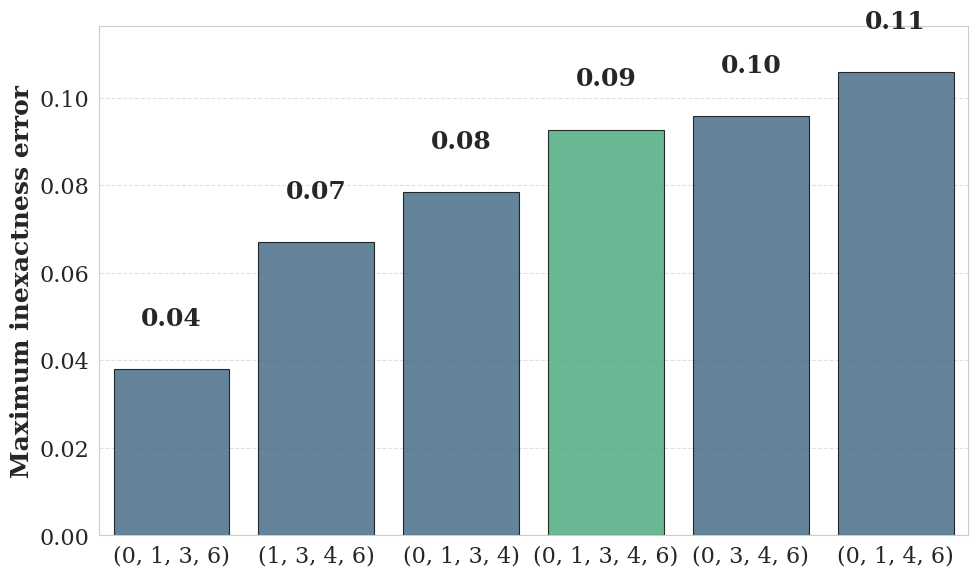

In [ ]:
# Set a clean, professional style with larger default font size
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14  # Increased base font size

filtered_keys = [key for key in diag_ratio_dict]

# Calculate maximum values for each key
bar_heights = [np.max(diag_ratio_dict[key]) for key in filtered_keys]

# Sort bars by height
sorted_indices = np.argsort(bar_heights)
sorted_keys = [filtered_keys[i] for i in sorted_indices]
sorted_heights = [bar_heights[i] for i in sorted_indices]

# Create more readable x-axis labels with proper set notation
x_labels = [str(key) for key in sorted_keys]

# Get tuple sizes for color coding
tuple_sizes = [len(t) for t in sorted_keys]
min_size = min(tuple_sizes)  # For safe color indexing

# Create a better color palette with distinct colors
palette = sns.color_palette('viridis', max(tuple_sizes) - min_size + 1)

# Create a figure with better dimensions
plt.figure(figsize=(10, 6))

# Create the bar plot with improved styling
ax = sns.barplot(x=x_labels, y=sorted_heights,
                palette=[palette[s - min_size] for s in tuple_sizes],
                edgecolor='black', linewidth=0.8, alpha=0.8)

# Add data values on top of bars
for i, v in enumerate(sorted_heights):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', fontsize=18, fontweight='bold')

# Improve the axes styling with larger font sizes
# plt.xlabel("Index set for the environments (base models)", fontsize=18, fontweight='bold')
plt.ylabel("Maximum inexactness error", fontsize=18, fontweight='bold')
# Title removed as requested

# Improve x-tick readability with larger font
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Add grid lines for better value reading
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Adjust y-axis to include padding
y_max = max(sorted_heights) * 1.1
plt.ylim(0, y_max)

# Enhance layout
plt.tight_layout()

# Save the figure with improved quality
plt.savefig(FIG_DIR + str(n_components) + '/noise_cor_subset.pdf', dpi=300, bbox_inches='tight')